In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
pd.set_option('display.max_rows', None)

## Extract list of all articles on Plato from contents page

In [ ]:
def _scrape(url):
    response = requests.get(url) # get HTML content
    soup = BeautifulSoup(response.content, 'html.parser') # parse
    hyperlinks = soup.find_all('a', href=lambda href: href and href.startswith('entries'))
    urls = [hyperlink.get('href') for hyperlink in hyperlinks] # Extract the URLs from the hyperlinks
    return urls

contents_list = _scrape("https://plato.stanford.edu/contents.html")
contents = pd.DataFrame(contents_list, columns=['href'])
contents['topic_name'] = contents['href'].apply(lambda x: x.split('/')[1])
contents['topic_name'] = contents['topic_name'].str.replace('-', ' ')
contents['url'] = contents['href'].apply(lambda x: 'https://plato.stanford.edu/' + x)
contents.head(1)

## Extract keywords from each URL

remove common words

In [ ]:
original_list = contents["topic_name"].tolist()
words_to_remove = {'abilities', 'action', 'analysis', 'argument', 'assertion', 'attention', 'belief', 'boundary', 'broad',
                   'categories', 'change', 'concepts', 'definitions',
                   'existence', 'properties','property','reference', 'respect',
                   'substance', 'time'}

def _remove(word_list):
    for word in words_to_remove:
        while word in word_list:
            word_list.remove(word)
    return word_list

topic_keywords_list = _remove(original_list)

In [ ]:
contents_little = contents.copy()
contents_little

In [ ]:
def _keywords(topic_name, url_input, keyword_input):
    found_keywords_list = [] # make empty list
    response = requests.get(url_input) #get html
    soup = BeautifulSoup(response.content, 'html.parser') #parse
    text = soup.get_text()
    for keyword in keyword_input:
        if keyword != topic_name:
            if keyword in text:
                found_keywords_list.append(keyword) 
    counts = {}
    for element in found_keywords_list: # consider replacing this with Counter
        if element in counts:
            counts[element] += 1
        else:
            counts[element] = 1
    sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    filtered_list = list(sorted_counts.keys())[:4] ##### toggle
    return(filtered_list)

def _rows(df):
    nested_list = []
    for index, row in tqdm(df.iterrows(), desc='Processing rows...'):
        output = _keywords(row["topic_name"], row['url'], topic_keywords_list)
        nested_list.append({row['topic_name']: output})
    return nested_list

In [ ]:
testresult = _rows(contents_little)

## Save export as csv

In [ ]:
result_list = []
for d in testresult:
    for k, v in d.items():
        row = [k] + v + [None] * (4 - len(v))
        result_list.append(row)

df_result = pd.DataFrame(result_list, columns=['topic_name'] + [f'output_{i+1}' for i in range(4)])
df_result

Just for insurance, export your df_result as a CSV here

## Read df or csv as nested list

In [37]:
result_list = []
for i in range(len(df_result)):
    nested_dict = {df_result.iloc[i]['topic_name']: [v for v in df_result.iloc[i].values[1:11] if v is not None]}
    result_list.append(nested_dict)

## Draw as graph

In [38]:
def _graph(output):
    graph_dict = {}
    for d in output:
        for key, value in d.items():
            if key not in graph_dict:
                graph_dict[key] = []
            for node in value:
                if node not in graph_dict:
                    graph_dict[node] = []
                graph_dict[key].append(node)
    return nx.DiGraph(graph_dict)

G = _graph(result_list)

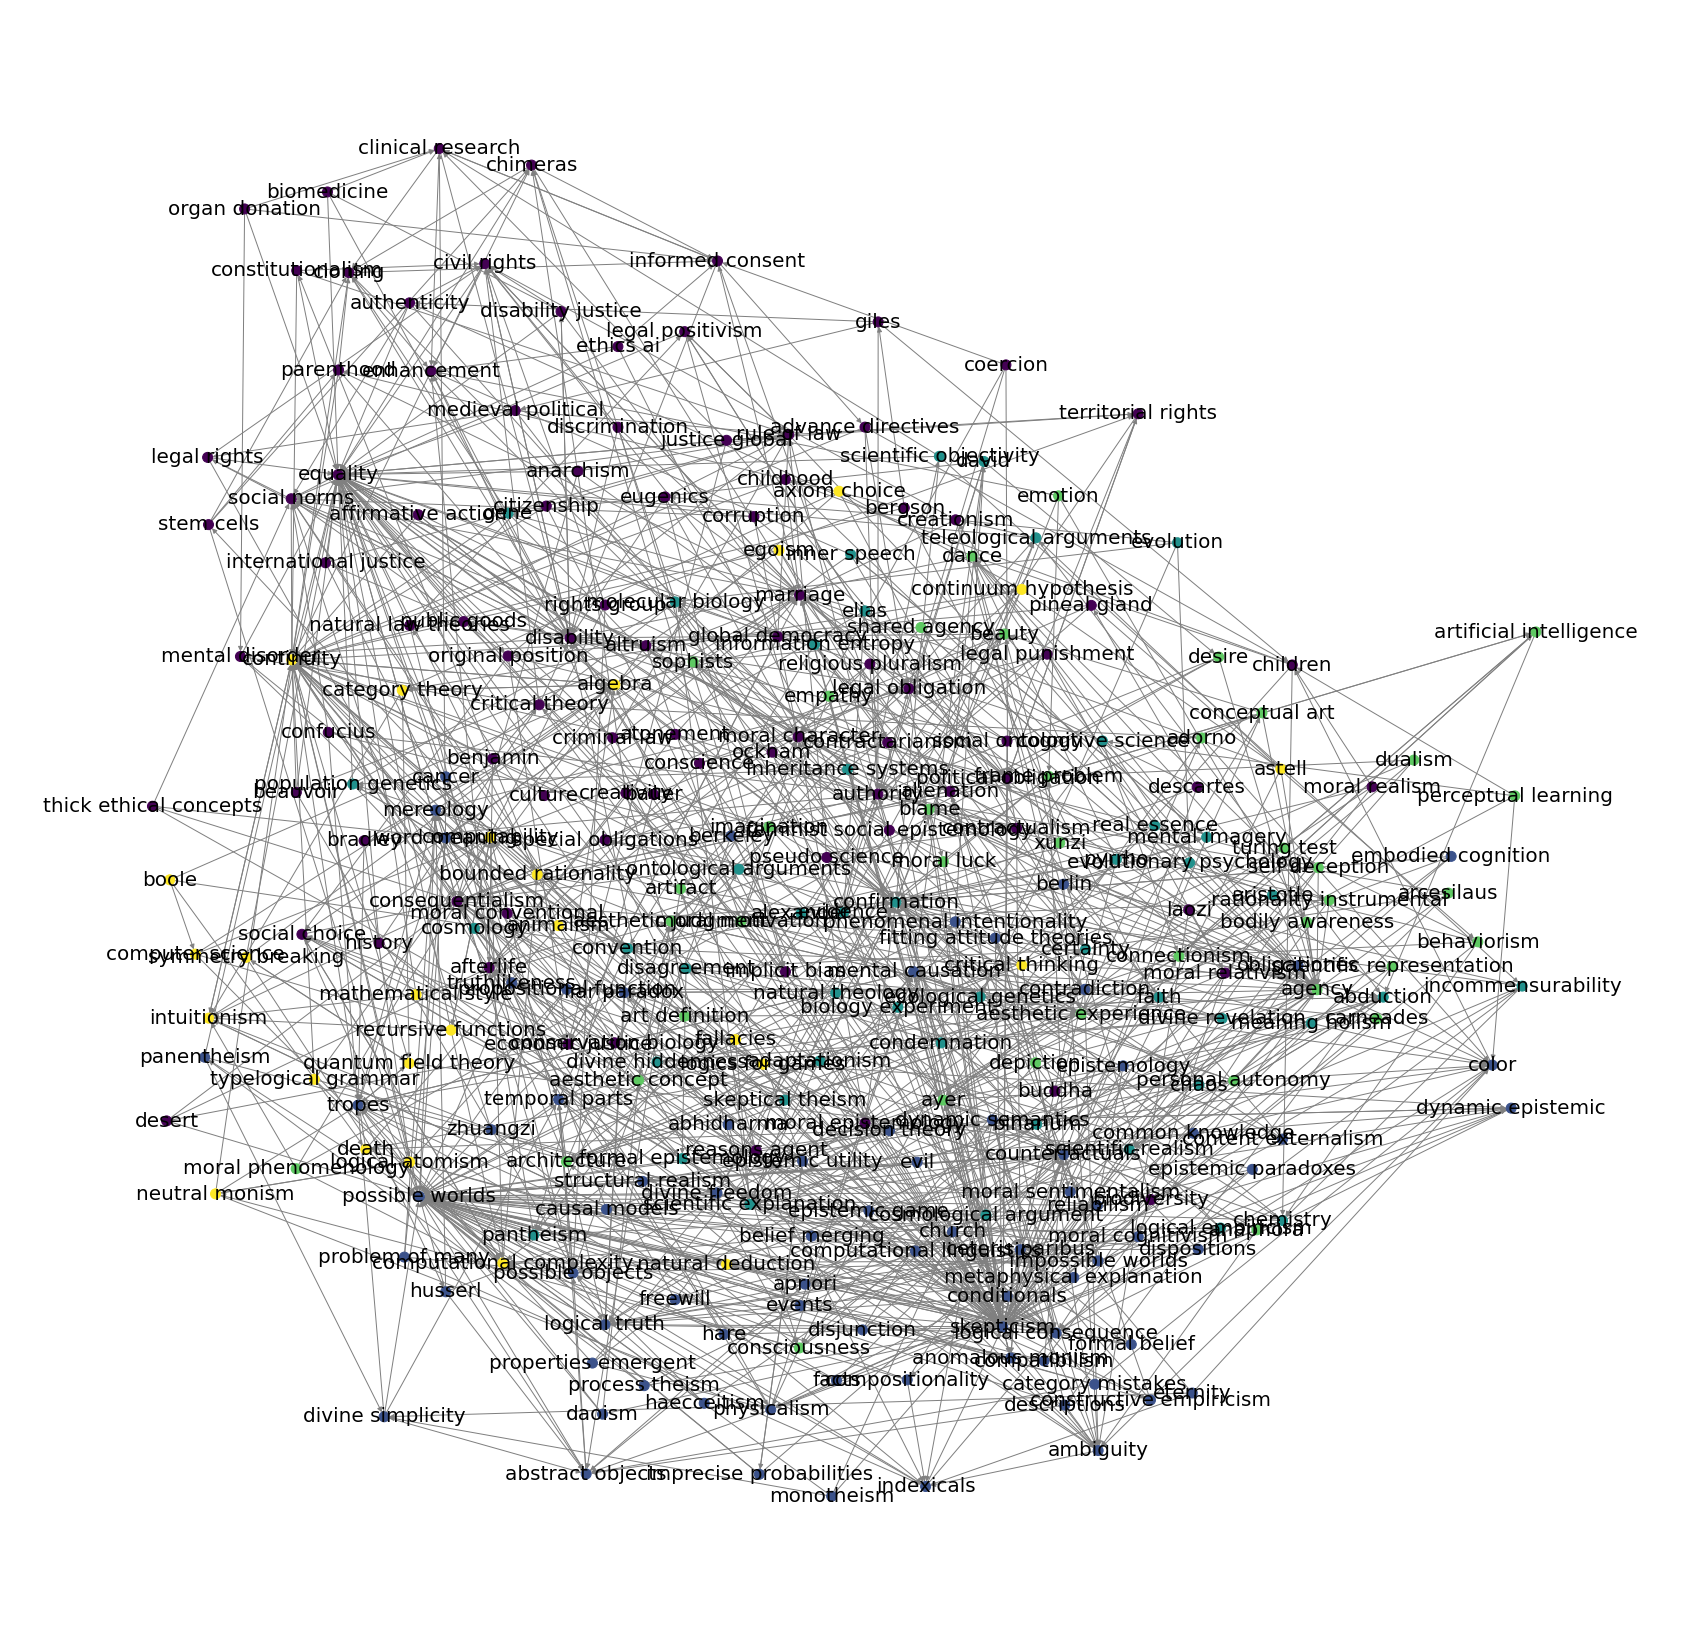

In [39]:
for node in list(G.nodes()):
    if G.in_degree(node) < 1:
        G.remove_node(node)

communities = list(greedy_modularity_communities(G, resolution=0.8))
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i
colours = [node_to_community[node] for node in G.nodes()]
        
# draw the resulting graph
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(G, pos=pos, with_labels=True, node_color=colours, node_size=100, font_size=20, edge_color='gray', width=1, ax=ax)
plt.show()

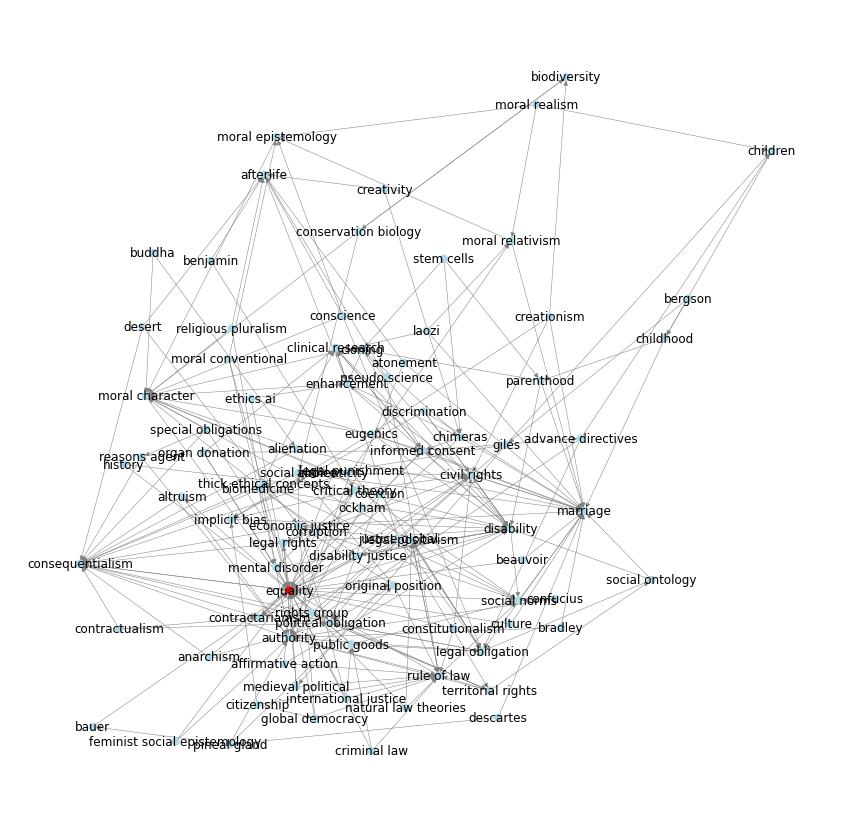

Community 0: Node equality has the highest in-degree of 31


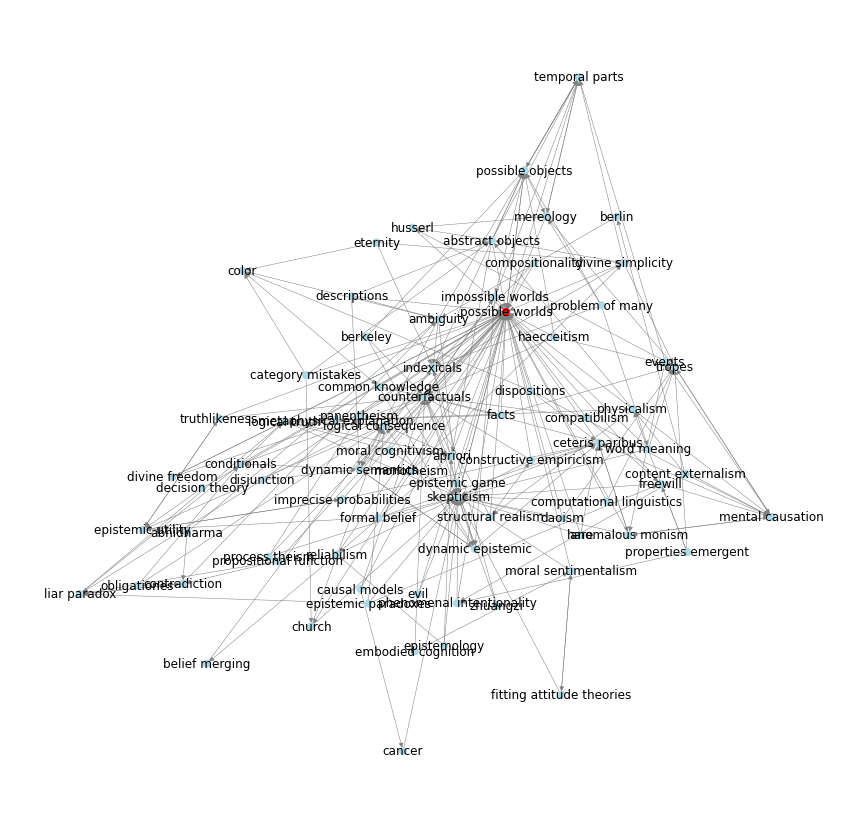

Community 1: Node possible worlds has the highest in-degree of 49


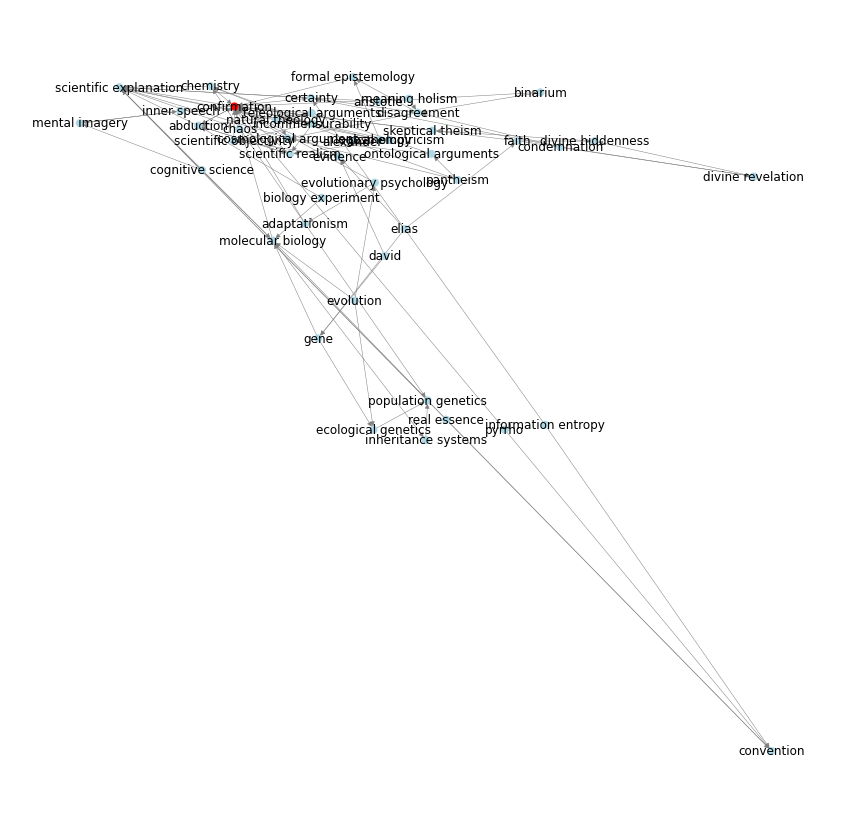

Community 2: Node confirmation has the highest in-degree of 19


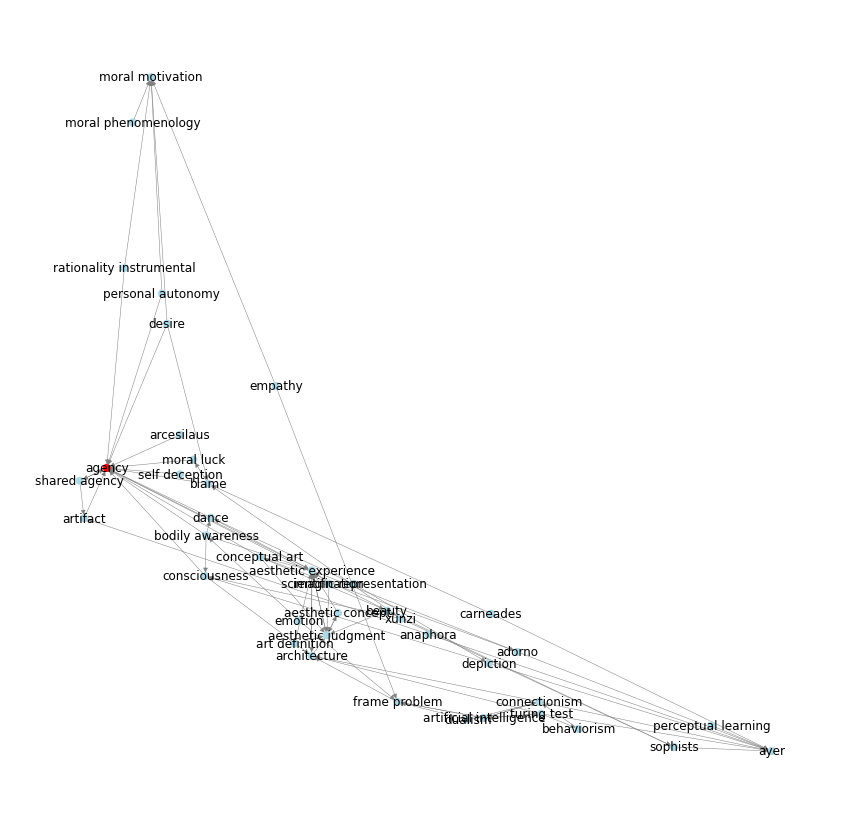

Community 3: Node agency has the highest in-degree of 15


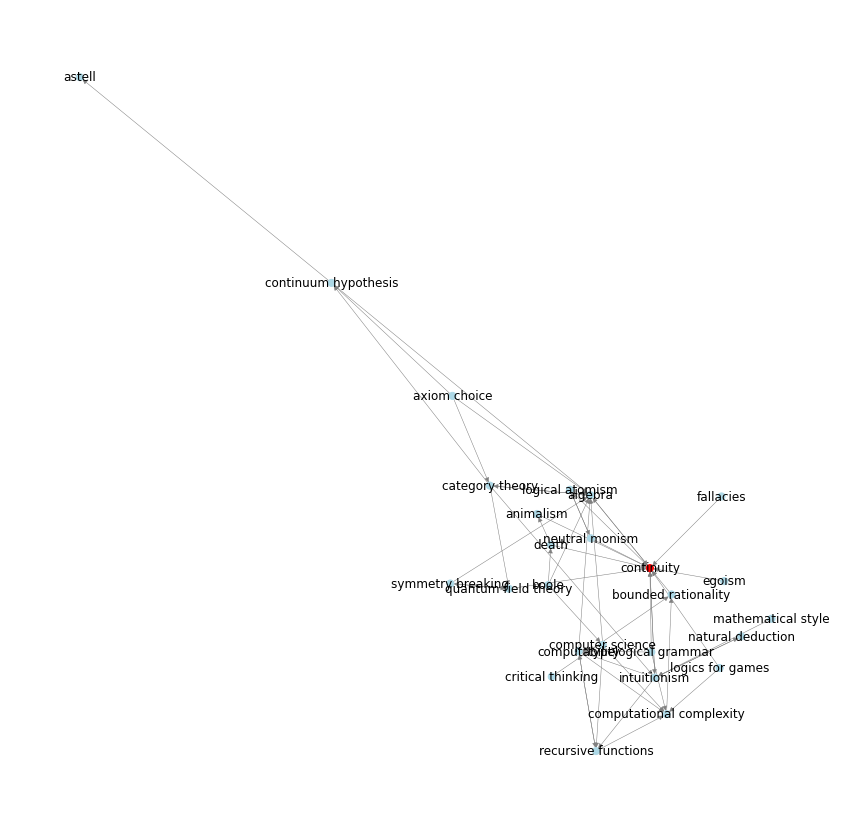

Community 4: Node continuity has the highest in-degree of 12


In [40]:
for i, community in enumerate(communities):
    H = G.subgraph(community)
    pos = nx.spring_layout(H)
    fig, ax = plt.subplots(figsize=(15, 15))
    node_colors = ['lightblue' for node in H.nodes()]
    node_sizes = [50 for node in H.nodes()]

    in_degrees = dict(H.in_degree())
    max_in_degree_node = max(in_degrees, key=in_degrees.get)
    node_colors[list(H.nodes()).index(max_in_degree_node)] = 'red'
    
    nx.draw(H, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=0.5, font_size=12)
    plt.show()
    print(f"Community {i}: Node \033[1m{max_in_degree_node}\033[0m has the highest in-degree of {in_degrees[max_in_degree_node]}")


## Edge analysis

In [23]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
df = pd.DataFrame({'node': list(G.nodes()), 'in_degree': list(in_degrees.values()),
                   'out_degree': list(out_degrees.values())})
df.sort_values(["in_degree"], ascending=False).reset_index(drop=None)

index                          node  in_degree  out_degree
0        1                    skepticism         77           4
1        5               possible worlds         62           4
2       39                      equality         51           4
3       10                    continuity         38           4
4        2                  confirmation         36           4
5       15                        agency         28           4
6       41              consequentialism         24           4
7       14                    disability         22           4
8       27               counterfactuals         22           4
9        7                      marriage         22           4
10      53                     authority         21           4
11      18                          ayer         19           4
12       3        scientific explanation         18           4
13       8           logical consequence         17           4
14      42               moral character         15           4
15      67                        tropes         14           4
16     112                   rule of law         13           4
17      11                     ambiguity         12           4
18      74                     afterlife         12           4
19      72                 logical truth         12           4
20      25              possible objects         11           4
21      79              mental causation         11           4
22     103                  social norms         11           4
23     117               ceteris paribus         11           4
24     156                  civil rights         11           4
25      99                       algebra         11           4
26      60          aesthetic experience         10           4
27      52              legal obligation         10           4
28      50                         color         10           4
29      26                temporal parts          9           4
30      30          political obligation          9           4
31     166      computational complexity          9           4
32      64                   physicalism          8           4
33      61            aesthetic judgment          8           4
34      36                   enhancement          8           4
35       0                     abduction          8           4
36      23              abstract objects          8           4
37      77              moral motivation          7           4
38       6                    indexicals          7           4
39      87                    convention          7           4
40     195                  intuitionism          7           4
41      63                     certainty          7           4
42     151              informed consent          7           4
43      45                  architecture          7           4
44     177                 computability          7           4
45     143                 social choice          7           4
46     105                         dance          6           4
47      68                       cloning          6           4
48      13                 contradiction          6           4
49      24                       apriori          6           4
50     173             molecular biology          6           4
51     158             clinical research          6           4
52       4            scientific realism          6           4
53      34             dynamic semantics          6           4
54     147                 connectionism          6           4
55     144                     mereology          6           4
56     135              contractarianism          5           4
57      22                         blame          5           4
58     220            moral epistemology          5           4
59      92         cosmological argument          5           4
60      40                      chimeras          5           4
61      21                        bea